## Семинар : "LSTM"

ФИО: Васильев Семён Михайлович

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch.autograd import Variable
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from IPython.display import clear_output
from torch.optim.lr_scheduler import StepLR
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

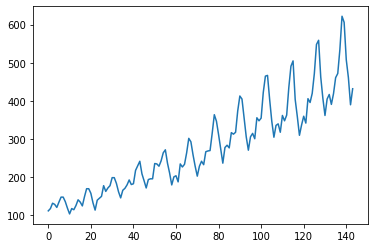

In [3]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [4]:
dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
dataset[:10]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984557],
       [0.08494207],
       [0.08494207],
       [0.06177607],
       [0.02895753]], dtype=float32)

In [6]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train_dataset, test_dataset = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train_dataset), len(test_dataset))

96 48


In [7]:
def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_forward : (i + look_back + look_forward), 0])
        
    return np.array(dataX), np.array(dataY)

In [8]:
dataX, dataY = create_dataset(dataset, 5, 2)

In [9]:
dataX[:10]

array([[0.01544401, 0.02702703, 0.05405405, 0.04826255, 0.03281853],
       [0.02702703, 0.05405405, 0.04826255, 0.03281853, 0.05984557],
       [0.05405405, 0.04826255, 0.03281853, 0.05984557, 0.08494207],
       [0.04826255, 0.03281853, 0.05984557, 0.08494207, 0.08494207],
       [0.03281853, 0.05984557, 0.08494207, 0.08494207, 0.06177607],
       [0.05984557, 0.08494207, 0.08494207, 0.06177607, 0.02895753],
       [0.08494207, 0.08494207, 0.06177607, 0.02895753, 0.        ],
       [0.08494207, 0.06177607, 0.02895753, 0.        , 0.02702703],
       [0.06177607, 0.02895753, 0.        , 0.02702703, 0.02123553],
       [0.02895753, 0.        , 0.02702703, 0.02123553, 0.04247104]],
      dtype=float32)

In [10]:
dataY[:10]

array([[0.05405405, 0.04826255, 0.03281853, 0.05984557, 0.08494207],
       [0.04826255, 0.03281853, 0.05984557, 0.08494207, 0.08494207],
       [0.03281853, 0.05984557, 0.08494207, 0.08494207, 0.06177607],
       [0.05984557, 0.08494207, 0.08494207, 0.06177607, 0.02895753],
       [0.08494207, 0.08494207, 0.06177607, 0.02895753, 0.        ],
       [0.08494207, 0.06177607, 0.02895753, 0.        , 0.02702703],
       [0.06177607, 0.02895753, 0.        , 0.02702703, 0.02123553],
       [0.02895753, 0.        , 0.02702703, 0.02123553, 0.04247104],
       [0.        , 0.02702703, 0.02123553, 0.04247104, 0.07142857],
       [0.02702703, 0.02123553, 0.04247104, 0.07142857, 0.05984557]],
      dtype=float32)

In [11]:
class RecNet(nn.Module):
    def __init__(self, model_type, input_size, hidden_size, 
                 seq_len, output_size, lin_hid_size=64):
        super(RecNet, self).__init__()
        self.model_type = model_type
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lin_hid_size = lin_hid_size
        self.seq_len = seq_len
        self.dense = nn.Sequential(
#             (nn.Linear(self.hidden_size * self.seq_len, self.output_size))
            nn.Linear(self.hidden_size * self.seq_len, self.lin_hid_size),
            nn.Tanh(),
            nn.Linear(self.lin_hid_size, self.output_size)            
        )
        if self.model_type == 'myLSTM':
            self.rec = LSTM(input_size, hidden_size)
        elif self.model_type == 'torchLSTM':
            self.rec = nn.LSTM(input_size, hidden_size)
        elif self.model_type == 'torchGRU':
            self.rec = nn.GRU(input_size, hidden_size)
        else:
            print('Unknown model')
        
    def forward(self, inputs):
#         inputs = inputs.view(inputs.size(0), 1, inputs.size(1)).permute(2, 0, 1)
        inputs = inputs.permute(2, 0, 1)
        bs = inputs.size(1)
        if self.model_type == 'myLSTM':
            hidden = (torch.zeros(bs, self.hidden_size),
                      torch.zeros(bs, self.hidden_size))
        if self.model_type == 'torchLSTM':
            hidden = (torch.zeros(1, bs, self.hidden_size),
                      torch.zeros(1, bs, self.hidden_size))
        if self.model_type == 'torchGRU':
            hidden = torch.zeros(1, bs, self.hidden_size)
        pred, hidden = self.rec.forward(inputs, hidden)
        pred = pred.permute(1, 0, 2)
        pred = pred.contiguous().view(bs, -1)
        res = self.dense(pred)
        res = res[:, 0]
        return res

In [12]:
def predict(network, start, pred_len):
    res = np.zeros(start.shape[0] + pred_len)
    res[:start.shape[0]] = start.reshape((len(start)))
    for i in range(pred_len):
        X = Variable(torch.Tensor(res[i:i+start.shape[0]]))
        X = X.view(1, 1, X.size(0))
        pred = network(X)
        res[i+start.shape[0]] = pred[-1]
    return res

In [13]:
def train(network, train_dataset, test_dataset, \
          look_back, epochs, batch_size, lr):
    input_size = 1
    output_size = 1

    loss = nn.MSELoss()
    optimizer = optim.Adam(network.parameters(), lr=lr)

    trainX, trainY = create_dataset(train_dataset, look_back)
    testX, testY = create_dataset(test_dataset, look_back)
    
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
    test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))

    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

    train_losses = []
    test_losses = []
    
    scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)

    for epoch in range(epochs):
        losses = []
        network.train()
        for X, y in train_loader:
            network.zero_grad()
            pred = network(X)
            y = y[:,-1]
#             print(pred, pred.size())
#             print(y, y.size())
#             print('=' * 20)
#             return
            batch_loss = loss(pred, y)
            losses.append(batch_loss.item())
            batch_loss.backward()
            optimizer.step()
        scheduler.step()
        train_losses.append(np.mean(losses))
        losses = []
        network.eval()
        for X, y in test_loader:
            pred = network(X)
            y = y[:,-1]
            batch_loss = loss(pred, y)
            losses.append(batch_loss.item())
        test_losses.append(np.mean(losses))
        if (epoch + 1) % 50 == 0:
            pred = predict(network, dataset[0: look_back], 150)
            clear_output(True)
            print(
                '\rEpoch {0}... (Train/Test) MSE: {1:.5f}/{2:.5f}' \
                .format(epoch, train_losses[-1], test_losses[-1])
            )
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_losses, label='Train')
            plt.plot(test_losses, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()

            plt.subplot(1, 2, 2)
            plt.plot(dataset, label='True')
            plt.plot(pred, label='Prediction')
            plt.legend()
            plt.grid()
            plt.show()

In [17]:
epochs = 2000
lin_hid_size = 16
batch_size = 42
lr = 0.01

Epoch 1999... (Train/Test) MSE: 0.00049/0.00732


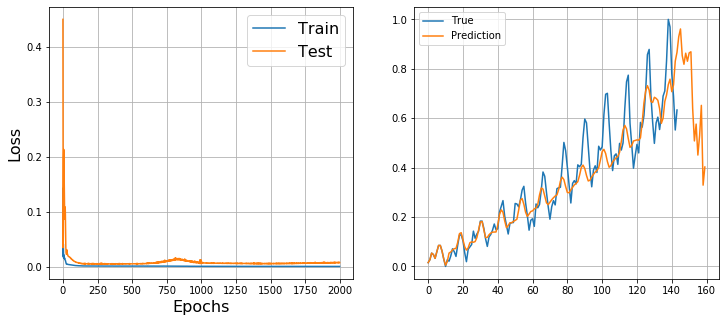

In [18]:
network = RecNet(
    model_type='myLSTM', input_size=1, 
    hidden_size=10, seq_len=10, output_size=1, lin_hid_size=lin_hid_size
)

train(
    network=network, train_dataset=train_dataset, 
    test_dataset=test_dataset, look_back=10, 
    epochs=epochs, batch_size=batch_size, lr=lr
)

Epoch 1999... (Train/Test) MSE: 0.00014/0.01012


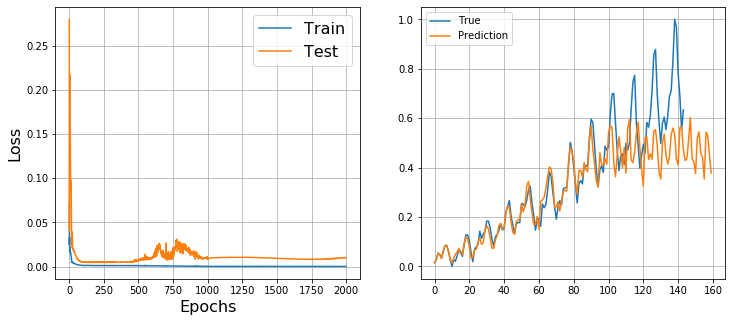

In [19]:
network = RecNet(
    model_type='myLSTM', input_size=1, 
    hidden_size=20, seq_len=10, output_size=1, lin_hid_size=lin_hid_size
)

train(
    network=network, train_dataset=train_dataset, 
    test_dataset=test_dataset, look_back=10, 
    epochs=epochs, batch_size=batch_size, lr=lr
)

Epoch 1999... (Train/Test) MSE: 0.00004/0.01035


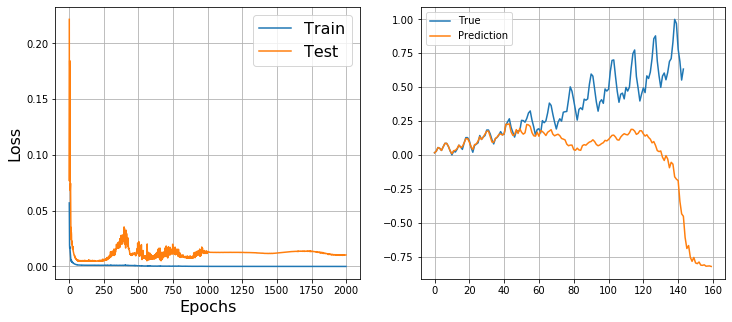

In [20]:
network = RecNet(
    model_type='myLSTM', input_size=1, 
    hidden_size=30, seq_len=10, output_size=1, lin_hid_size=lin_hid_size
)

train(
    network=network, train_dataset=train_dataset, 
    test_dataset=test_dataset, look_back=10, 
    epochs=epochs, batch_size=batch_size, lr=lr
)

Epoch 1999... (Train/Test) MSE: 0.00025/0.00176


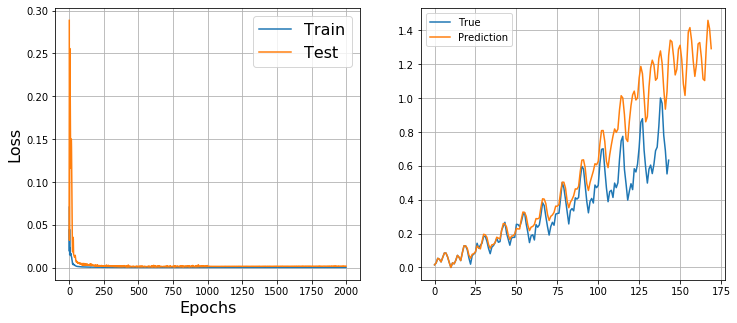

In [21]:
network = RecNet(
    model_type='myLSTM', input_size=1, 
    hidden_size=10, seq_len=20, output_size=1, lin_hid_size=lin_hid_size
)

train(
    network=network, train_dataset=train_dataset, 
    test_dataset=test_dataset, look_back=20, 
    epochs=epochs, batch_size=batch_size, lr=lr
)

Epoch 1999... (Train/Test) MSE: 0.00024/0.00300


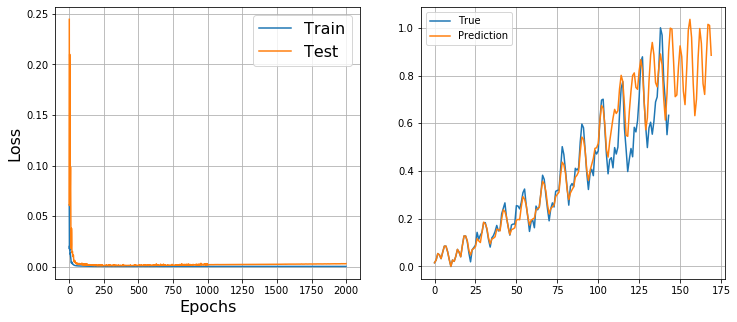

In [22]:
network = RecNet(
    model_type='myLSTM', input_size=1, 
    hidden_size=20, seq_len=20, output_size=1, lin_hid_size=lin_hid_size
)

train(
    network=network, train_dataset=train_dataset, 
    test_dataset=test_dataset, look_back=20, 
    epochs=epochs, batch_size=batch_size, lr=lr
)

Epoch 1999... (Train/Test) MSE: 0.00025/0.00227


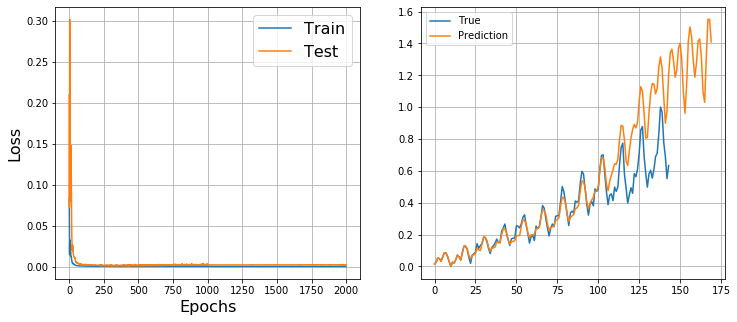

In [23]:
network = RecNet(
    model_type='myLSTM', input_size=1, 
    hidden_size=30, seq_len=20, output_size=1, lin_hid_size=lin_hid_size
)

train(
    network=network, train_dataset=train_dataset, 
    test_dataset=test_dataset, look_back=20, 
    epochs=epochs, batch_size=batch_size, lr=lr
)

Epoch 1999... (Train/Test) MSE: 0.00018/0.01101


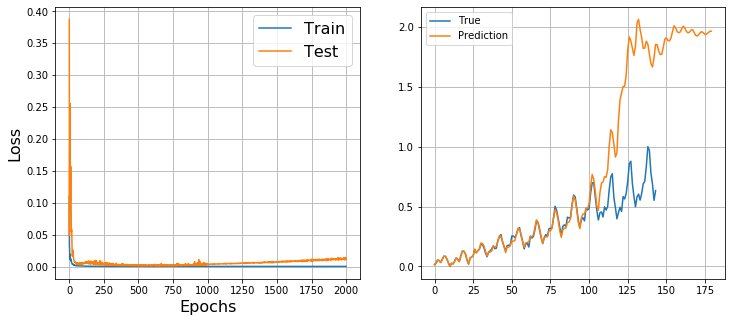

In [24]:
network = RecNet(
    model_type='myLSTM', input_size=1, 
    hidden_size=10, seq_len=30, output_size=1, lin_hid_size=lin_hid_size
)

train(
    network=network, train_dataset=train_dataset, 
    test_dataset=test_dataset, look_back=30, 
    epochs=epochs, batch_size=batch_size, lr=lr
)

Epoch 1999... (Train/Test) MSE: 0.00017/0.01342


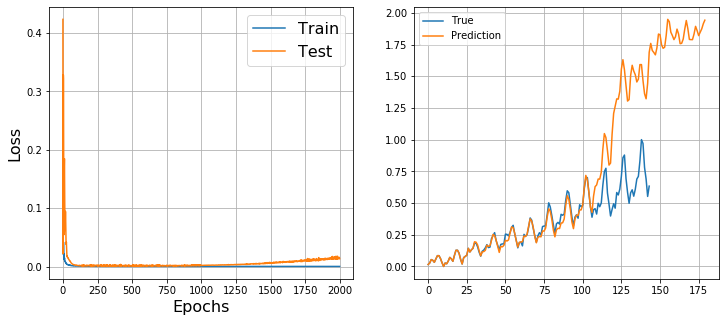

In [25]:
network = RecNet(
    model_type='myLSTM', input_size=1, 
    hidden_size=20, seq_len=30, output_size=1, lin_hid_size=lin_hid_size
)

train(
    network=network, train_dataset=train_dataset, 
    test_dataset=test_dataset, look_back=30, 
    epochs=epochs, batch_size=batch_size, lr=lr
)

Epoch 1999... (Train/Test) MSE: 0.00011/0.04862


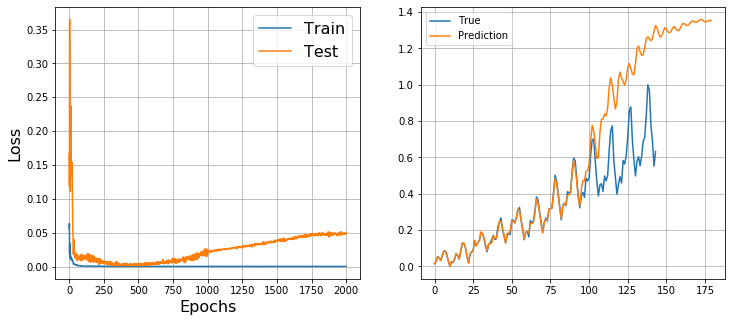

In [27]:
network = RecNet(
    model_type='myLSTM', input_size=1, 
    hidden_size=30, seq_len=30, output_size=1, lin_hid_size=lin_hid_size
)

train(
    network=network, train_dataset=train_dataset, 
    test_dataset=test_dataset, look_back=30, 
    epochs=epochs, batch_size=batch_size, lr=lr
)

Epoch 1999... (Train/Test) MSE: 0.00024/0.00281


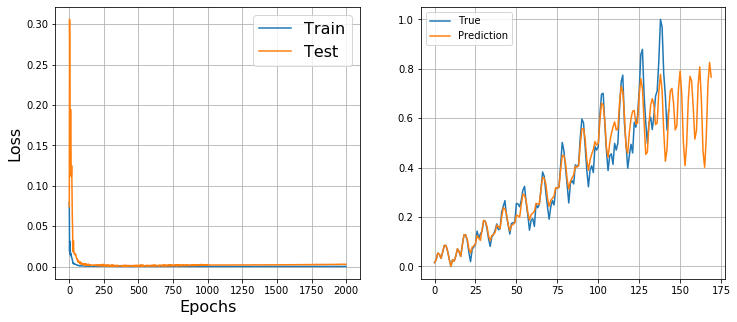

In [28]:
network = RecNet(
    model_type='torchLSTM', input_size=1, 
    hidden_size=10, seq_len=20, output_size=1, lin_hid_size=lin_hid_size
)

train(
    network=network, train_dataset=train_dataset, 
    test_dataset=test_dataset, look_back=20, 
    epochs=epochs, batch_size=batch_size, lr=lr
)

Epoch 1999... (Train/Test) MSE: 0.00024/0.00986


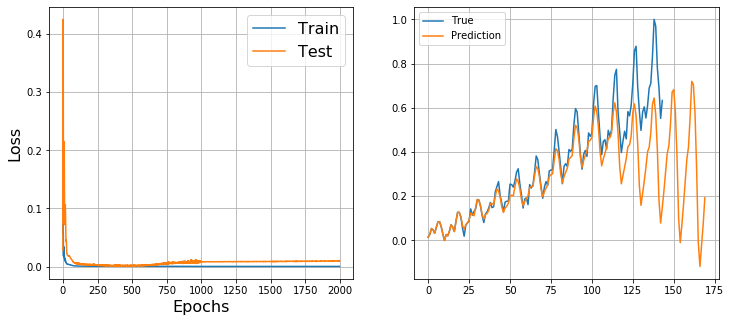

In [29]:
network = RecNet(
    model_type='torchGRU', input_size=1, 
    hidden_size=10, seq_len=20, output_size=1, lin_hid_size=lin_hid_size
)

train(
    network=network, train_dataset=train_dataset, 
    test_dataset=test_dataset, look_back=20, 
    epochs=epochs, batch_size=batch_size, lr=lr
)

### Финальное предсказание

In [45]:
network = RecNet(
    model_type='torchLSTM', input_size=1, 
    hidden_size=10, seq_len=45, output_size=1, lin_hid_size=8
)

Epoch 399... (Train/Test) MSE: 0.00090/0.00114


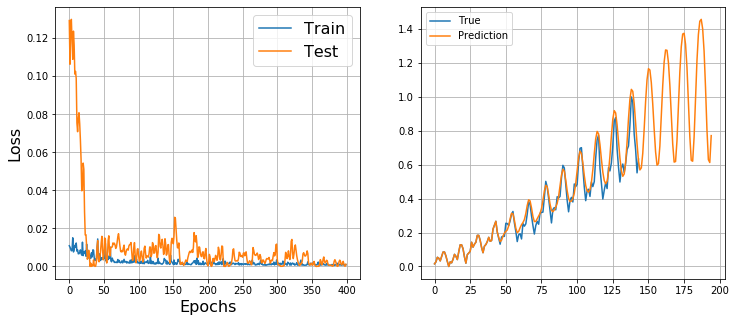

In [46]:
train(
    network=network, train_dataset=train_dataset, 
    test_dataset=test_dataset, look_back=45, 
    epochs=400, batch_size=24, lr=0.001
)

Epoch 199... (Train/Test) MSE: 0.00221/0.00006


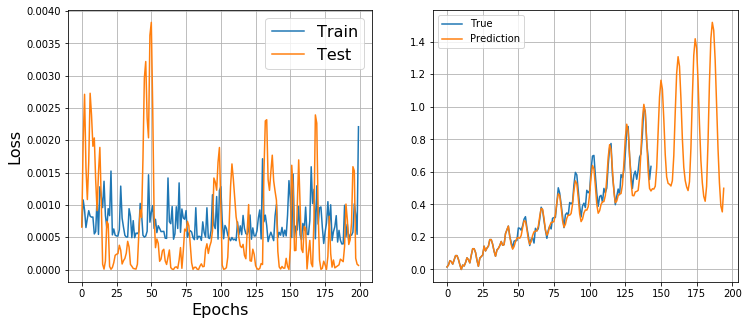

In [47]:
train(
    network=network, train_dataset=train_dataset, 
    test_dataset=test_dataset, look_back=45, 
    epochs=200, batch_size=24, lr=0.0005
)

Epoch 199... (Train/Test) MSE: 0.00043/0.00016


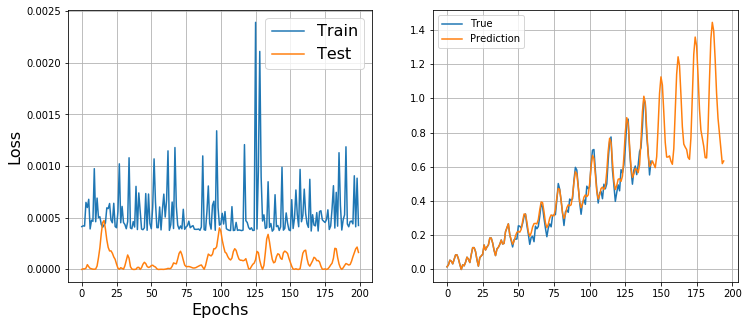

In [49]:
train(
    network=network, train_dataset=train_dataset, 
    test_dataset=test_dataset, look_back=45, 
    epochs=200, batch_size=24, lr=0.0001
)

In [65]:
pred = predict(network, dataset[train_size - 45: train_size], 150)[:test_size]

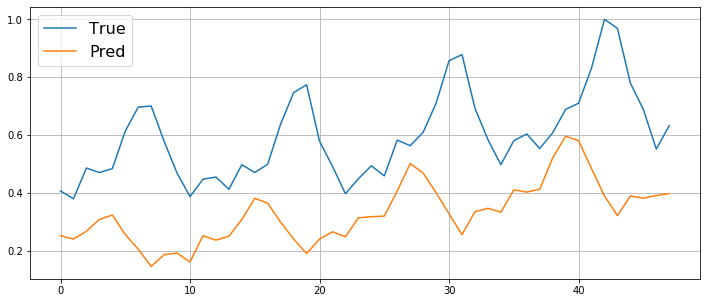

In [67]:
plt.figure(figsize=(12, 5))
plt.plot(dataset[train_size:], label='True')
plt.plot(pred, label='Pred')
plt.legend(loc=0, fontsize=16)
plt.grid()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: